# EDA and data transformation notebook
This notebook will contain:
- exploratory data analysis on oil price time series data exploring 
    - distributions of both raw and log prices
    - highlight event timelines in the plots to check where events occured in the data
    - transform the data based on result of exploratory analysis like stationarity and the like


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns

In [5]:
#load event data
event_df = pd.read_csv('../data/processed/oil_events.csv', parse_dates=['start_date'])
print("Event Data loaded successfully ✅")

Event Data loaded successfully ✅


C:\Users\adoni\AppData\Local\Temp\ipykernel_32876\2020086081.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  event_df = pd.read_csv('../data/processed/oil_events.csv', parse_dates=['start_date'])


In [6]:
event_df["start_date"] = event_df["start_date"].str.replace("\u2011", "-", regex=False,) # replace non standard dash with standard dash
event_df["start_date"]= pd.to_datetime(event_df["start_date"]) # parse the date column to datetime format

print("Event start date parsed successfully ✅")
print(event_df.start_date.dtype)


Event start date parsed successfully ✅
datetime64[ns]


In [7]:
# top rows of event data
event_df.head()

,title,start_date,duration_weeks,category,description,impact_direction,influence_level,source_links,notes
0,OPEC quota breakdown and post‑glut Brent slump,1987-12-01,40,OPEC_decision,OPEC’s failure to enforce quotas after the 198...,down,high,['https://www.latimes.com/archives/la‑xpm‑1987...,40 weeks appears plausible given the mid‑1987 ...
1,Iraq’s invasion of Kuwait,1990-08-02,12,conflict,Saddam’s 1990 invasion removed ~4.3 mb/d from ...,up,very_high,['https://en.wikipedia.org/wiki/1990_Oil_Price...,Quick spike pattern aligns with 12‑week window.
2,Asian financial crisis & oversupply glut,1997-10-01,60,economic_shock,Demand in Asia fell nearly 1.0–1.2 mb/d as eco...,down,high,['https://econ.worldbank.org/ai‑spotlight/oil‑...,Decline spanned mid‑1997 to early 1999 (≈60 we...
3,US invasion of Iraq (early boost),2003-03-20,8,conflict,Pre‑invasion risk premium lifted Brent ~33 % (...,up,medium,['https://en.wikipedia.org/wiki/Oil_markets_in...,Posterior timing fits an 8‑week spike rather t...
4,China Demand Surge & Iraq War Supply Disruptions,2004-01-01,208,demand_supply_imbalance,Rapid industrialization in China drove unprece...,up,very_high,['https://www.eia.gov/todayinenergy/detail.php...,Duration reflects the extended period of tight...


In [8]:
# load_data
df = pd.read_csv('../data/processed/BrentOilPrices_transformed.csv', parse_dates=['Date'])
print("Oil Data loaded successfully ✅")

Oil Data loaded successfully ✅


In [9]:
# explore how the top entries look like
df.head()

,Date,Price,Log_Return,Rolling_Mean,Rolling_Std_Log
0,1987-07-02,19.25,0.014125,NaN,NaN
1,1987-07-03,19.33,0.004147,NaN,NaN
2,1987-07-06,19.48,0.007730,NaN,NaN
3,1987-07-07,19.50,0.001026,NaN,NaN
4,1987-07-08,19.48,-0.001026,NaN,NaN


In [10]:
# basic info about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8981 entries, 0 to 8980
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             8981 non-null   datetime64[ns]
 1   Price            8981 non-null   float64       
 2   Log_Return       8981 non-null   float64       
 3   Rolling_Mean     8952 non-null   float64       
 4   Rolling_Std_Log  8952 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 350.9 KB


we can see that the the data contains two columns one time column and one price both dont have any null values and the date column is correctly parced to date time

In [11]:
# data sanity check - summary statistics
df.describe()

,Date,Price,Log_Return,Rolling_Mean,Rolling_Std_Log
count,8981,8981.000000,8981.000000,8952.000000,8952.000000
mean,2005-03-04 13:22:00.788331008,48.519762,0.000178,48.491577,0.021603
min,1987-07-02 00:00:00,9.100000,-0.643699,10.004333,0.005807
25%,1996-04-24 00:00:00,19.100000,-0.011222,19.064583,0.014949
50%,2005-02-23 00:00:00,39.050000,0.000395,39.974667,0.019328
75%,2014-01-21 00:00:00,70.360000,0.012197,70.455667,0.024446
max,2022-11-14 00:00:00,143.950000,0.412023,135.606667,0.187314
std,NaN,32.870215,0.025571,32.733110,0.013665


Insight:
1. Price Volatility & Distribution

- Extreme Range: Prices span from $9.10 (min, likely 1998–1999 oil glut or 2020 COVID crash) to $143.95 (max, likely 2008 or 2022 crisis).

- High Volatility:

    - Standard deviation (±$32.86) is 68% of the mean ($48.42) → Prices swing wildly.

    - 25th percentile ($19.05) vs. 75th percentile ($70.09) shows dramatic shifts between eras.

2. Price Regimes (Eras)

- Low-Price Era: 25% of data ≤ $19.05 (likely 1987–2000, OPEC gluts).

- Medium-Price Era: Median = $38.57 (2000s stabilization).

- High-Price Era: 25% of data ≥ $70.09 (post-2000 crises, demand surges).

3. Temporal Coverage

Data spans 35 years (1987–2022), covering major events like:

- 1990 Gulf War (sharp price spikes).

- 2008 Financial Crisis (all-time highs).

- 2020 COVID demand crash (lows near $9.10).

## EDA: Time series Visualization

c:\Users\adoni\Desktop\KAIM COURSE\WEEK-10\ChangePointDetection\.venv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\adoni\Desktop\KAIM COURSE\WEEK-10\ChangePointDetection\.venv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\adoni\AppData\Local\Temp\ipykernel_32876\2499827192.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


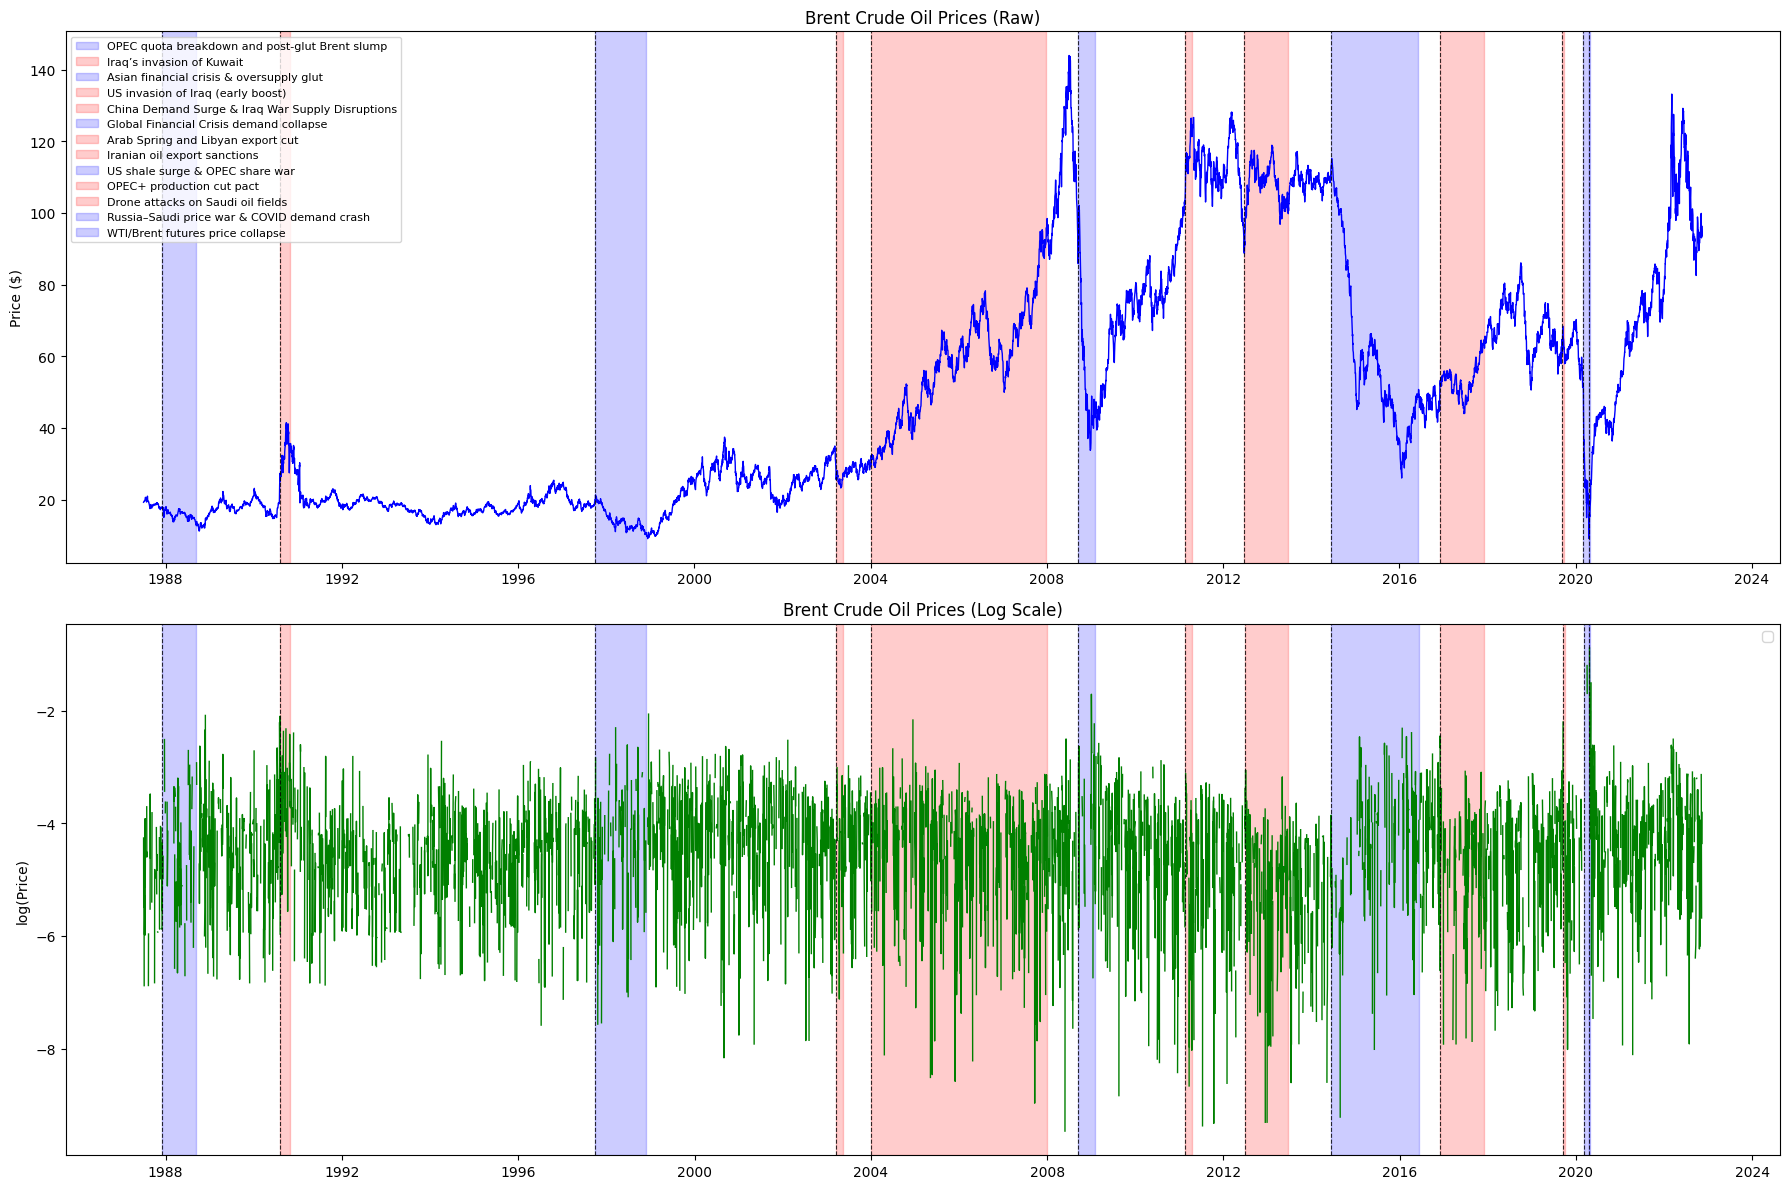

In [12]:
# raw vs log-price plots with events highlighted
import numpy as np
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12))

# 1. Raw Prices
ax1.plot(df['Date'], df['Price'], lw=1, color='blue')
ax1.set_title("Brent Crude Oil Prices (Raw)")
ax1.set_ylabel("Price ($)")

# 2. Log Prices
ax2.plot(df['Date'], np.log(df['Log_Return']), lw=1, color='green')
ax2.set_title("Brent Crude Oil Prices (Log Scale)")
ax2.set_ylabel("log(Price)")

# Add event bands
for ax in [ax1, ax2]:
    for _, event in event_df.iterrows():
        ax.axvspan(
            event["start_date"],
            pd.to_datetime(event["start_date"]) + pd.Timedelta(weeks=event["duration_weeks"]),
            color="red" if event["impact_direction"] == "up" else "blue",  # Red for price surges, blue for drops
            alpha=0.2,
            label=event["title"] if ax == ax1 else ""  # Avoid duplicate labels
        )
        # Dashed line at start date
        ax.axvline(
            event["start_date"],
            color="black",
            linestyle="--",
            linewidth=0.8,
            alpha=0.8
        ),
            

    if ax == ax1:
        ax.legend(loc="upper left", fontsize=8)
plt.tight_layout()
plt.legend()
plt.show()

From the above plot, we can see that:

- Most of the marked events align well with major price movements in the data, indicating that the annotations are relevant and grounded.

- The raw price plot is heavily skewed and highly volatile, with sudden sharp spikes during crisis periods. This highlights the non-stationary and heteroskedastic nature of the raw price data.

- In contrast, the log-transformed price plot smooths out extreme volatility, and heavy-tail skewness is significantly reduced. The distribution appears more symmetric and stable over time.

- For modeling:

    - The raw price data would benefit from non-Gaussian likelihoods, such as a Student-t distribution, to handle extreme values and heavy tails.

    - The log-transformed prices are better suited for Gaussian likelihood-based models, making them a reasonable choice for changepoint detection or Bayesian regression approaches.



## EDA: Distributinal properties

In [13]:
# create a log return column 
df['Log_Return'] = (np.log(df['Price']).diff()).dropna()
print("Log Return column added successfully ✅")

Log Return column added successfully ✅


In [14]:
print("nan values in data:")
print(df.isna().sum())

# remove nan valuse
df = df.dropna()
df.head()

nan values in data:
Date                0
Price               0
Log_Return          1
Rolling_Mean       29
Rolling_Std_Log    29
dtype: int64


,Date,Price,Log_Return,Rolling_Mean,Rolling_Std_Log
29,1987-08-12,19.50,0.002567,19.896667,0.015790
30,1987-08-13,19.40,-0.005141,19.901667,0.015624
31,1987-08-14,19.25,-0.007762,19.899000,0.015673
32,1987-08-17,18.85,-0.020998,19.878000,0.016049
33,1987-08-18,18.75,-0.005319,19.853000,0.016062


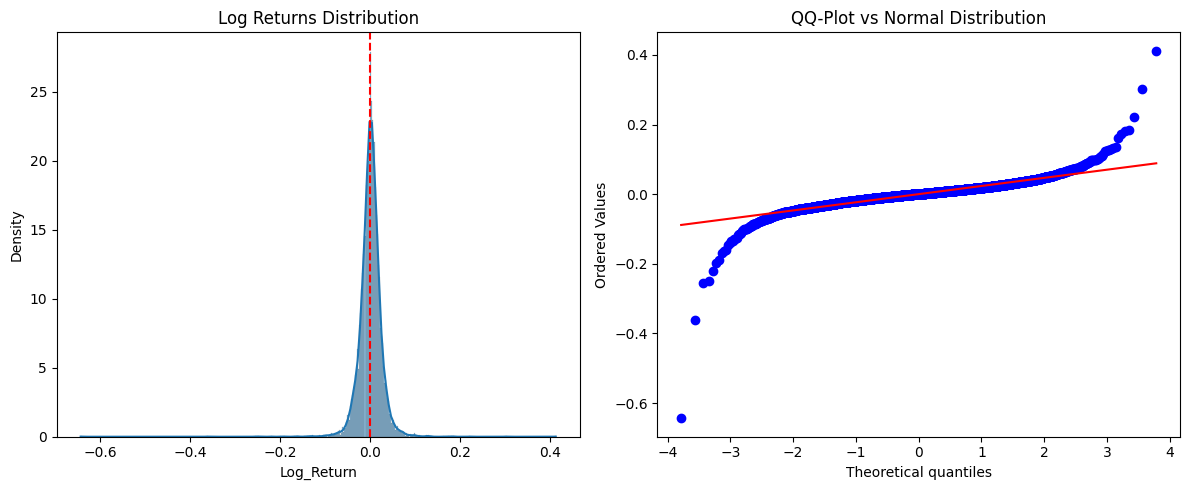

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 1. Histogram + KDE
sns.histplot(df['Log_Return'].dropna(), kde=True, ax=ax1, stat="density")
ax1.set_title("Log Returns Distribution")
ax1.axvline(0, color='red', linestyle='--')

# 2. QQ-Plot
stats.probplot(df['Log_Return'].dropna(), dist="norm", plot=ax2)
ax2.set_title("QQ-Plot vs Normal Distribution")

plt.tight_layout()
plt.show()

## Histogram & QQ-Plot Insights
Observations:
- Fat Tails:

    - Histogram shows thicker tails (extreme values beyond ±0.2) than a Gaussian.

    - QQ-Plot curves upward/downward at ends → heavy-tailed distribution.

- Negative Skew:

    - Left tail (crash events) is heavier than right tail (spikes).

### **Modeling Implications**:
- Avoid Gaussian Likelihood: Underestimates extreme events.

- Use **StudentT** Likelihood

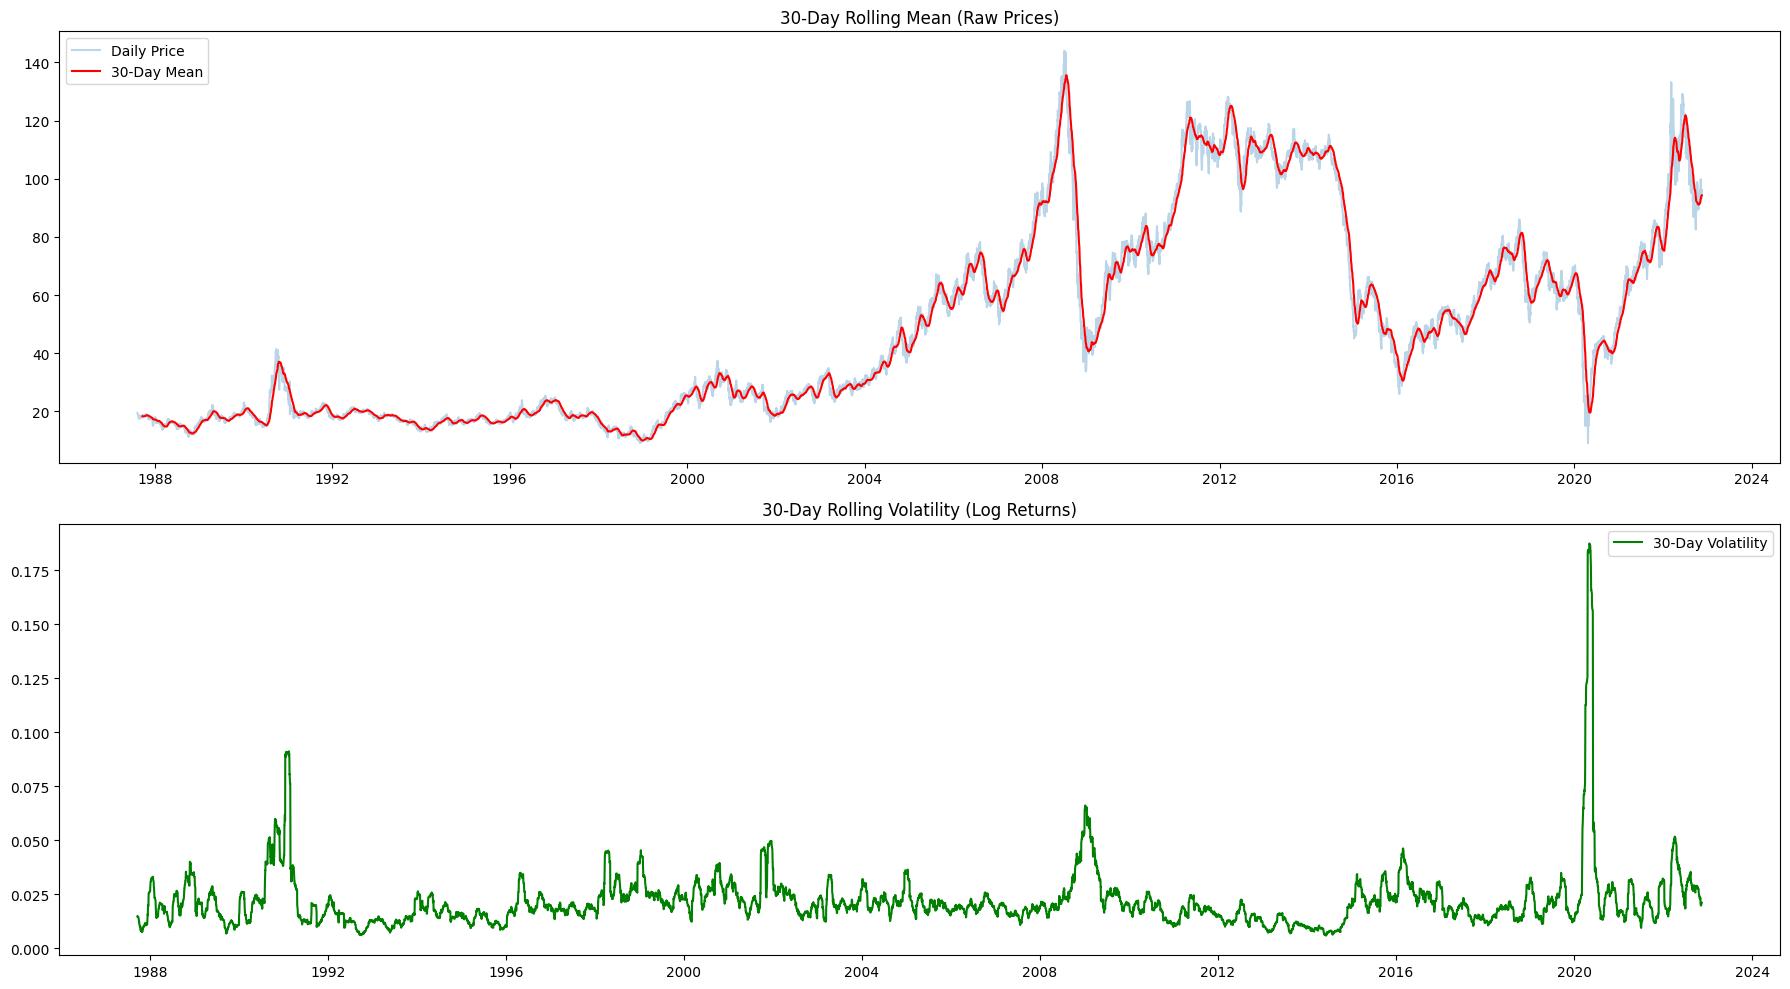

In [16]:
# rolling mean and standard deviation plots
df['Rolling_Mean'] = df['Price'].rolling(30).mean()  # For raw prices
df['Rolling_Std_Log'] = df['Log_Return'].rolling(30).std()  # For volatility

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10))

# 1. Rolling Mean (Raw Prices)
ax1.plot(df['Date'], df['Price'], label='Daily Price', alpha=0.3)
ax1.plot(df['Date'], df['Rolling_Mean'], label='30-Day Mean', color='red')
ax1.set_title("30-Day Rolling Mean (Raw Prices)")
ax1.legend()

# 2. Rolling Std (Log Returns)
ax2.plot(df['Date'][df['Rolling_Std_Log'].notna()], df['Rolling_Std_Log'].dropna(), label='30-Day Volatility', color='green')
ax2.set_title("30-Day Rolling Volatility (Log Returns)")
ax2.legend()

plt.tight_layout()
plt.show()

### Insight:
1. Rolling Mean (Raw Prices) - Key Insights
Visible Regime Shifts:
    - 2003–2008: Steady upward trend → Matches China demand boom & Iraq Wa.

    - 2008–2009: Sharp drop → Financial crisis.

    - 2020: COVID crash and recovery.

    - 2014–2016: Gradual decline → OPEC price war.
NOTE: it allignes with out time series plots

2. Rolling Volatility (Log Returns) - Critical Findings
Volatility Clusters:
    - 2008–2009: Sharp peak (Financial Crisis).

    - 2020: Extreme spike (COVID crash).

    - 2014–2016: Elevated volatility (OPEC war, shale boom).

    - 1990–1991: Smaller spike (Gulf War).

In [17]:
# statistics of log return
print("Log Return Statistics:")
df.Log_Return.describe()

Log Return Statistics:


count    8952.000000
mean        0.000176
std         0.025597
min        -0.643699
25%        -0.011259
50%         0.000392
75%         0.012211
max         0.412023
Name: Log_Return, dtype: float64

Statistics:
- Mean ≈ 0 (0.000179): Confirms log returns are mean-centered.

- Std = 0.0255: Typical daily volatility is ~2.55%.

- Extremes: Min (-64%), Max (+41%) → Fat tails (affirms StudentT likelihood).

### Combined modeling **implication**:
## **Model Setup (Draft)**  
1. **Data**: `Log_Return` (StudentT), keep `Price` for levels.  
2. **Priors**:  
   - `sigma ~ InverseGamma(3, 0.05)`  
   - `tau ~ Mixture([event_windows, uniform], w=[0.7, 0.3])`  
3. **Flexibility**:  
   - Tune `nu` (4→3?) if tails are heavier.  
   - Adjust event window width (±30→±60?) after full EDA.  

# ADF/KPSS tests

In [18]:
from statsmodels.tsa.stattools import adfuller, kpss
adf_result = adfuller(df["Log_Return"].dropna())
kpss_result = kpss(df["Log_Return"].dropna())
print(f"ADF p-value: {adf_result[1]:.10f}")
print(f"KPSS p-value: {kpss_result[1]:.4f}")

ADF p-value: 0.0000000000
KPSS p-value: 0.1000


C:\Users\adoni\AppData\Local\Temp\ipykernel_32876\3587065000.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df["Log_Return"].dropna())


### Stationarity Tests  
- **ADF**: p ≈ 0 → No unit root (stationary).  
- **KPSS**: p = 0.10 → No deterministic trend.  
- **Conclusion**: Log returns are clean for volatility regime modeling.  

In [19]:
# save transformed data with log return columns
df.to_csv("../data/processed/BrentOilPrices_transformed.csv", index=False)
print("Transformed Data Saved successfully✅")

Transformed Data Saved successfully✅


# Final modeling decisions
1. Core Model Structure
Target Variable: Log_Return
    - Transformation: np.log(df["Price"] / df["Price"].shift(1))

    - Properties: Stationary (ADF p≈0, KPSS p=0.10), fat-tailed (StudentT).

    - Likelihood: StudentT
    - Volatility Prior: InverseGamma
2. Changepoint Detection
Soft Event Priors (Your Idea!)
    - 70% weight: ±30 days around event start dates.

    - 30% weight: Uniform over full timeline.

**Validation Checks:**
- Traceplots: Ensure tau and sigma converge (no divergent samples).

- Posterior Checks: Verify changepoints align with volatility spikes.

**Fallback Options:**
- If tau is too diffuse, tighten event windows (±15d) or increase weight (w=[0.8, 0.2]).
- If modles do not converge well in pymc we will resort to raptures for multiple cahnge point detection